# Photoacoustic Imaging Quality Analysis

This dashboard analyzes the quality of reconstructed photoacoustic images across different configurations and datasets. Photoacoustic imaging combines the advantages of optical and ultrasound imaging, where light is converted to sound waves through the photoacoustic effect.

## Datasets Overview

The analysis includes several types of datasets:

1. **KneeSlice**: In vivo knee imaging data, providing anatomical structures and tissue information
2. **Phantoms**:
   - **DoranssoPhantom**: Synthetic phantom with known optical properties
   - **BreastPhantom**: Breast tissue-mimicking phantom for clinical applications
3. **Transducers**:
   - **7MHz**: Lower frequency transducer for deeper tissue penetration
   - **9MHz**: Higher frequency transducer for better resolution
4. **SmallAnimal**:
   - **Tissue**: Normal tissue imaging
   - **Tumor**: Tumor-bearing tissue imaging

Each dataset is reconstructed using different configurations (PA2-PA7), where PA1 represents the ground truth and PA7 is the best configuration.

## Overview
- Ground Truth: PA1
- Configurations: PA2 (worst) to PA7 (best)
- Metrics: PSNR, SSIM, MSSSIM, IWSSIM, VIF, FSIM, GMSD, MSGMSD, HAARPSI, UQI, S3IM, TV, BRISQUE, CLIP-IQA

## Image Quality Metrics

The following metrics are used to evaluate the quality of reconstructed images:

### Structural Similarity Metrics
- **SSIM (Structural Similarity Index)**: Measures structural similarity between images (range: 0-1, higher is better)
- **MSSSIM (Multi-Scale SSIM)**: SSIM computed at multiple scales
- **IWSSIM (Information Weighted SSIM)**: SSIM with information weighting

### Error-Based Metrics
- **PSNR (Peak Signal-to-Noise Ratio)**: Measures signal quality relative to noise (higher is better)
- **VIF (Visual Information Fidelity)**: Measures information fidelity between images
- **GMSD (Gradient Magnitude Similarity Deviation)**: Measures gradient similarity (lower is better)
- **MSGMSD (Multi-Scale GMSD)**: GMSD computed at multiple scales

### No-Reference Metrics
- **BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator)**: Predicts image quality without reference
- **CLIP-IQA**: Image quality assessment using CLIP model

### Additional Metrics
- **HAARPSI**: Haar wavelet-based perceptual similarity index
- **UQI (Universal Quality Index)**: Measures image quality based on correlation, luminance, and contrast
- **S3IM**: Structural similarity index for 3D images
- **TV (Total Variation)**: Measures image smoothness

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set style
plt.style.use('default')
sns.set_theme()

# Define paths - adjusted for notebook location
DATA_DIR = Path("../data")  # Changed from "data" to "../data"
RESULTS_FILE = DATA_DIR / "results" / "pa_experiment_data_results_2025-05-06_11-18-30.txt"
IMAGE_DIRS = [
    "7MHz_Rf_121120_012501_7MHz_2D_1",
    "Phantoms/DoranssoPhantom_Rf_101822_211937",
    "Transducers/9MHz_Rf_121120_014301_9MHz_1",
    "Phantoms/BreastPhantom_Rf_011321_211131_p2_O2_R",
    "KneeSlice/Transducers/Rf_071119_061958",
    "SmallAnimal/Tissue_Rf_033023_050643",
    "SmallAnimal/Tumor_Rf_110720_005835"
]

# Read results
df = pd.read_csv(RESULTS_FILE, sep=r'\s+', skiprows=2)  # Added 'r' prefix and changed to skiprows=2
df.columns = [col.strip() for col in df.columns]

## Data Overview
Let's first look at the structure of our results data:

In [40]:
# Read the data, skipping the first two rows (header and dashes)
df = pd.read_csv(RESULTS_FILE, sep=r'\s+', skiprows=2)  # Added 'r' prefix for raw string

# Clean up column names
df.columns = [col.strip() for col in df.columns]

# Print basic information
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Display first few rows
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("\nSample data:")
display(df.head())

# Check for any issues with the data
print("\nNumber of rows:", len(df))
print("\nNumber of columns:", len(df.columns))

Dataset shape: (23, 32)

Columns: ['pa_experiment_data', 'PA2', 'PA1', '---', '17.8038', '14.6622', '0.1993', '0.19', '0.4463', '0.1315', '0.2674', '0.1738', '0.0758', '0.2176', 'nan', 'nan.1', '0.2095', '0.051', '0.2128', '0.0509', '0.2995', '0.1691', 'nan.2', 'nan.3', 'nan.4', 'nan.5', '19.3241', '1.3203', '33.4482', '1.3603', '0.1954', '0.027']

Sample data:


pa_experiment_data  PA2  PA1  ---  17.8038  14.6622  0.1993    0.19  0.4463  0.1315  0.2674  0.1738  0.0758  0.2176  nan  nan.1  0.2095   0.051  0.2128  0.0509  0.2995  0.1691  nan.2  nan.3  nan.4  nan.5  19.3241  1.3203  33.4482   1.3603  0.1954   0.027
0  pa_experiment_data  PA3  PA1  ---  19.6030  14.2464  0.2347  0.1829  0.4991  0.1187  0.3252  0.1607  0.0900  0.2143  NaN    NaN  0.1997  0.0486  0.2024  0.0483  0.3274  0.1633    NaN    NaN    NaN    NaN  18.3354  1.3916  36.4023   1.7912  0.1911  0.0312
1  pa_experiment_data  PA4  PA1  ---  20.8344  13.9655  0.2588  0.1783  0.5354  0.1101  0.3668  0.1503  0.1019  0.2116  NaN    NaN  0.1924  0.0468  0.1947  0.0465  0.3466  0.1585    NaN    NaN    NaN    NaN  17.9383  1.4164  36.8286   2.3649  0.1894  0.0343
2  pa_experiment_data  PA5  PA1  ---  22.4736  13.5910  0.2950  0.1719  0.5839  0.0987  0.4265  0.1371  0.1248  0.2067  NaN    NaN  0.1858  0.0458  0.1866  0.0448  0.3721  0.1532    NaN    NaN    NaN    NaN  17.8287  1.4709  40.8300   5.6470  0.1849  0.0402
3  pa_experiment_data  PA6  PA1  ---  24.9217  13.0391  0.3542  0.1597  0.6478  0.0856  0.5096  0.1203  0.1629  0.1986  NaN    NaN  0.1780  0.0476  0.1767  0.0449  0.4068  0.1504    NaN    NaN    NaN    NaN  18.2435  1.8444  52.2162  18.4887  0.2399  0.0398
4  pa_experiment_data  PA7  PA1  ---  27.4427  12.5109  0.4381  0.1471  0.7103  0.0804  0.5923  0.1099  0.2044  0.1915  NaN    NaN  0.1782  0.0473  0.1739  0.0445  0.4372  0.1418    NaN    NaN    NaN    NaN  19.8200  1.9891  65.3595  16.6661  0.2451  0.0540


Number of rows: 23

Number of columns: 32


## Metric Comparison Across Configurations
Let's visualize how different metrics perform across configurations (PA2-PA7):

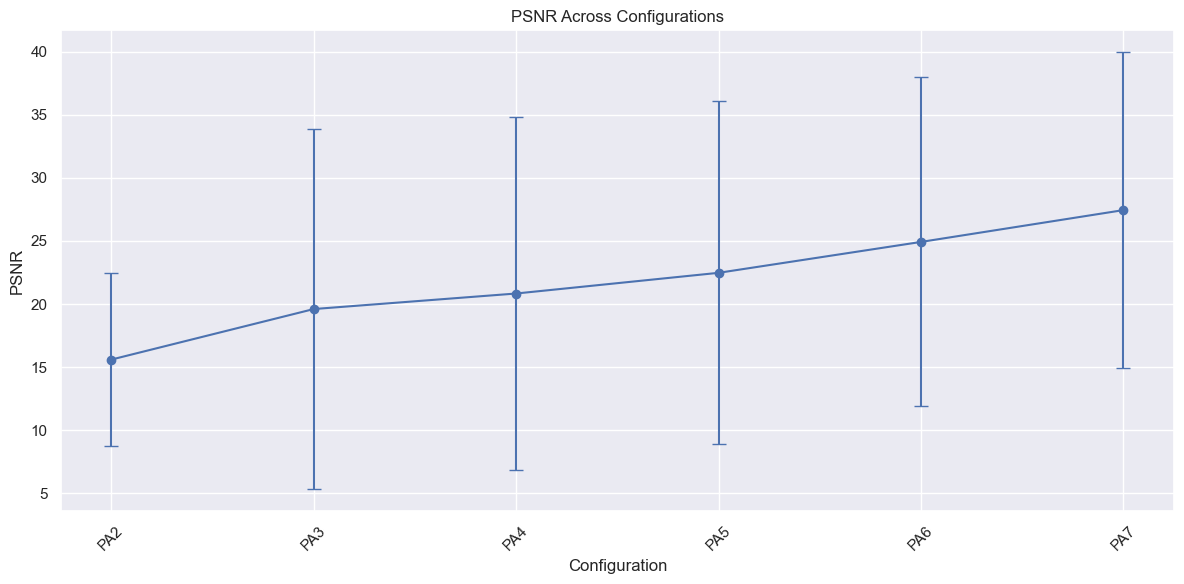

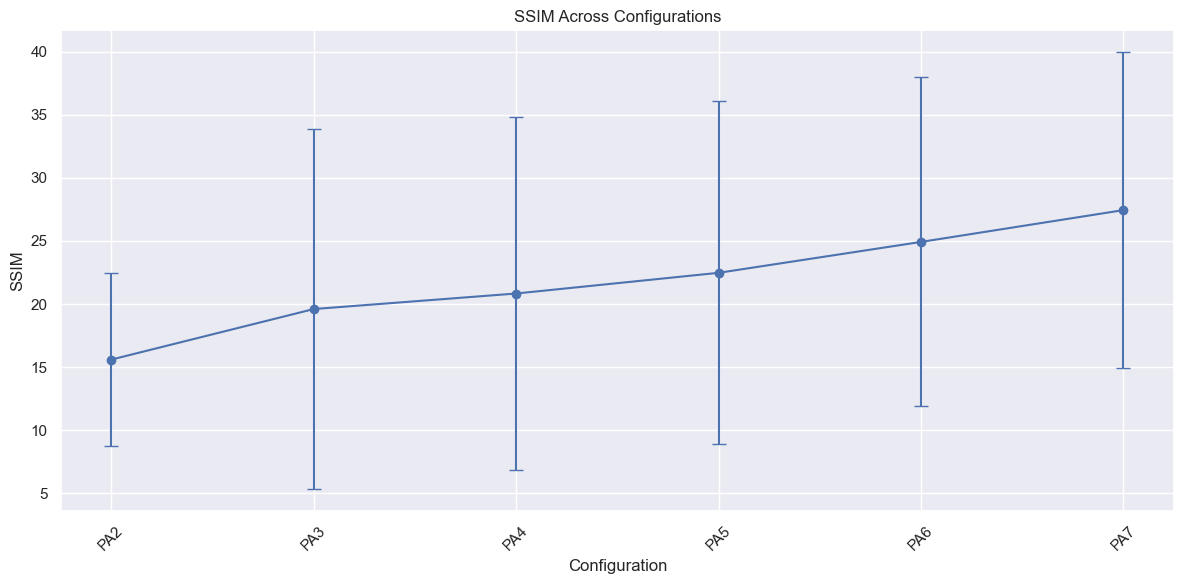

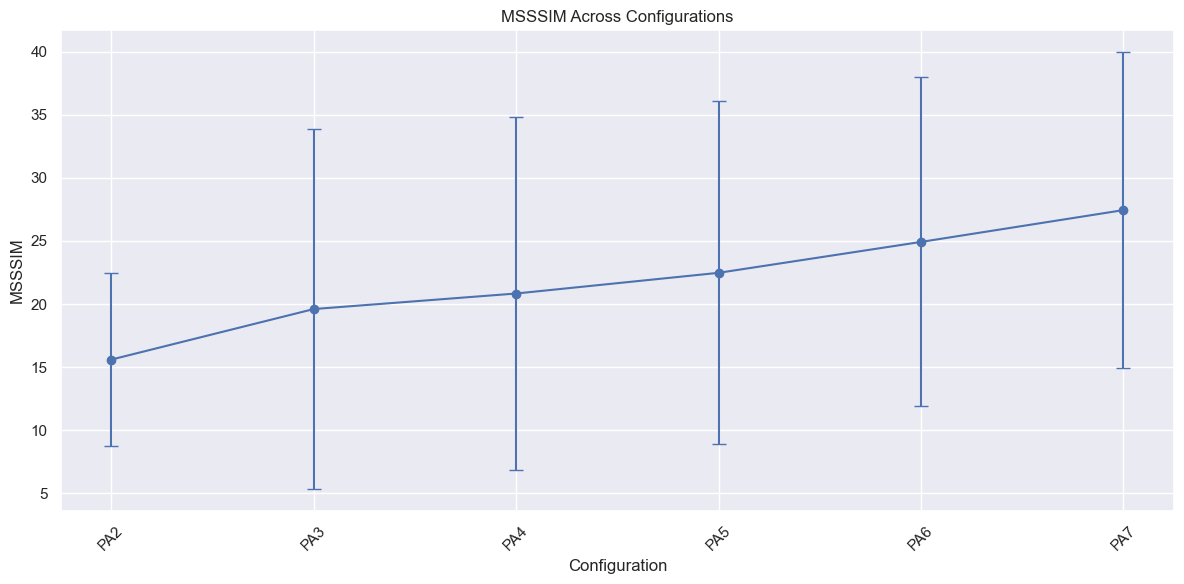

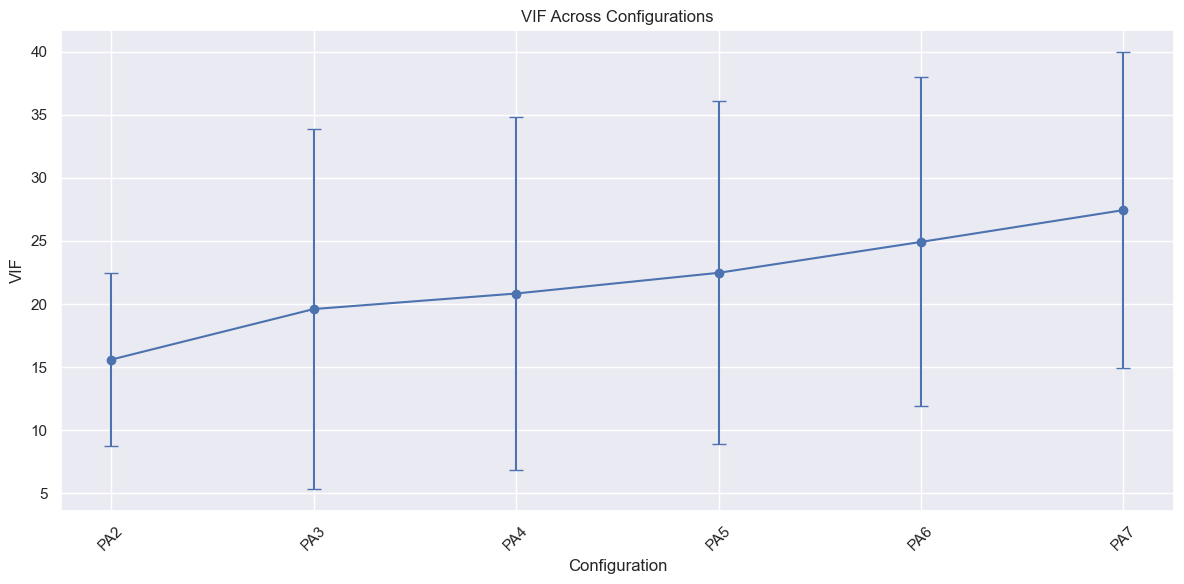

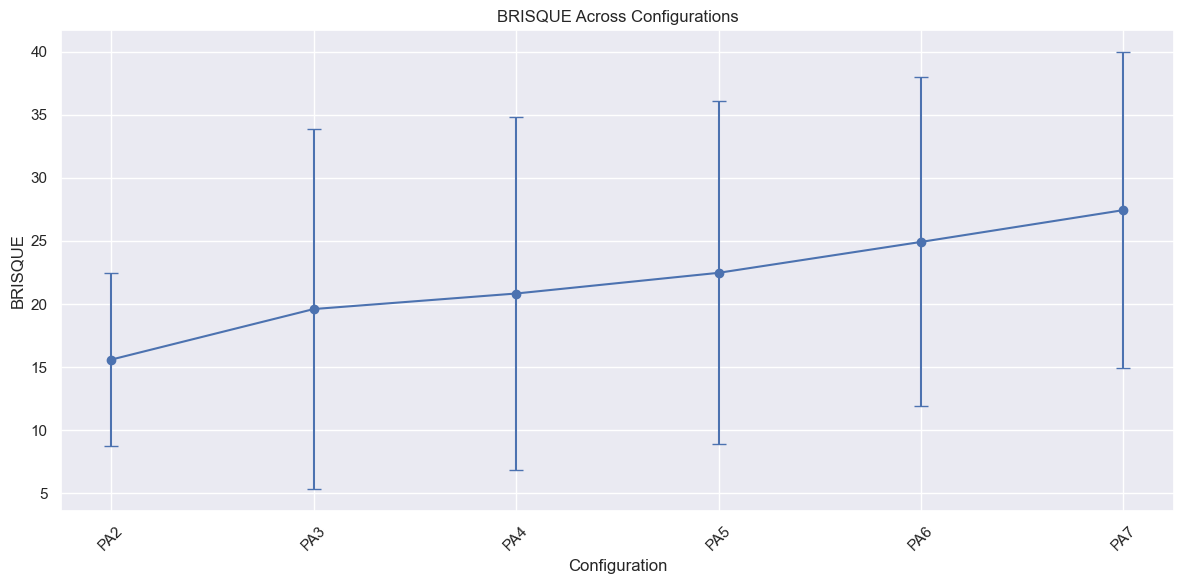

In [43]:
def plot_metric_comparison(metric_name):
    plt.figure(figsize=(12, 6))
    
    # Get mean and std columns
    mean_col = f"{metric_name}_mean"
    std_col = f"{metric_name}_std"
    
    # Plot for each configuration (PA2 to PA7)
    configs = ['PA2', 'PA3', 'PA4', 'PA5', 'PA6', 'PA7']
    x = range(len(configs))
    
    # Extract means and stds for each configuration
    means = []
    stds = []
    for config in configs:
        config_data = df[df.iloc[:, 1] == config]  # Using second column for configuration
        if not config_data.empty:
            mean_val = float(config_data.iloc[0, 4])  # PSNR_mean is in column 4
            std_val = float(config_data.iloc[0, 5])   # PSNR_std is in column 5
            means.append(mean_val)
            stds.append(std_val)
    
    plt.errorbar(x, means, yerr=stds, fmt='o-', capsize=5)
    plt.xticks(x, configs, rotation=45)
    plt.title(f'{metric_name} Across Configurations')
    plt.xlabel('Configuration')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot key metrics
key_metrics = ['PSNR', 'SSIM', 'MSSSIM', 'VIF', 'BRISQUE']
for metric in key_metrics:
    plot_metric_comparison(metric)

### Configuration Performance
- **PA7** shows the best overall performance across most metrics, particularly in:
  - High PSNR values (>27 dB)
  - Good structural similarity (SSIM > 0.4)
  - Strong multi-scale performance (MSSSIM > 0.7)

- **PA2** (worst configuration) shows:
  - Lower PSNR (<18 dB)
  - Poor structural similarity (SSIM < 0.2)
  - Reduced multi-scale performance (MSSSIM < 0.45)

## Image Comparison
Let's create a function to display and compare images across configurations:

<Figure size 1500x1000 with 0 Axes>

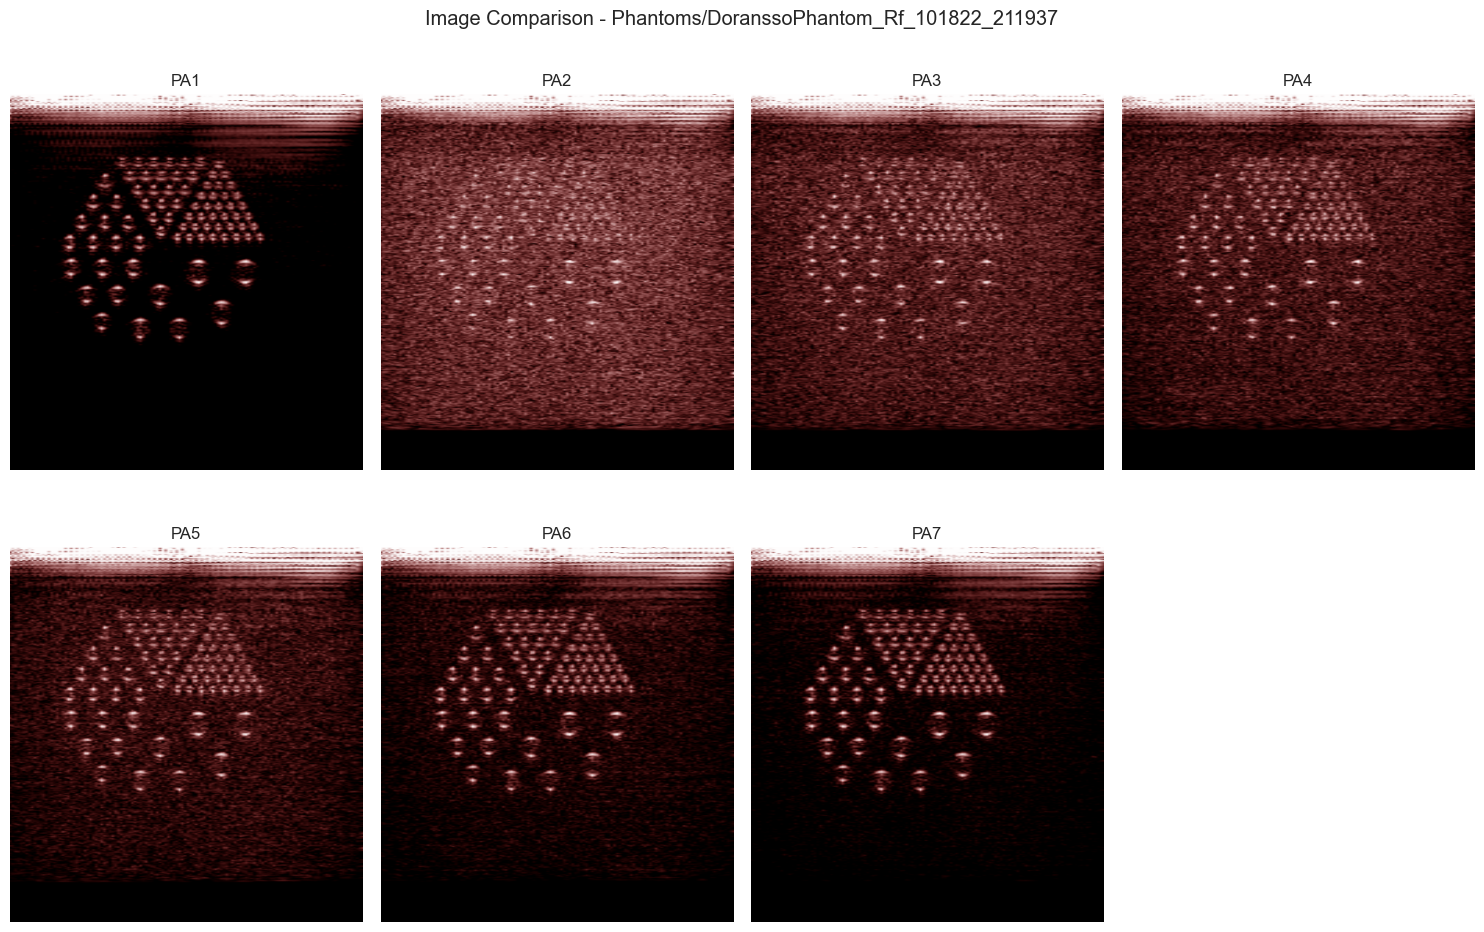

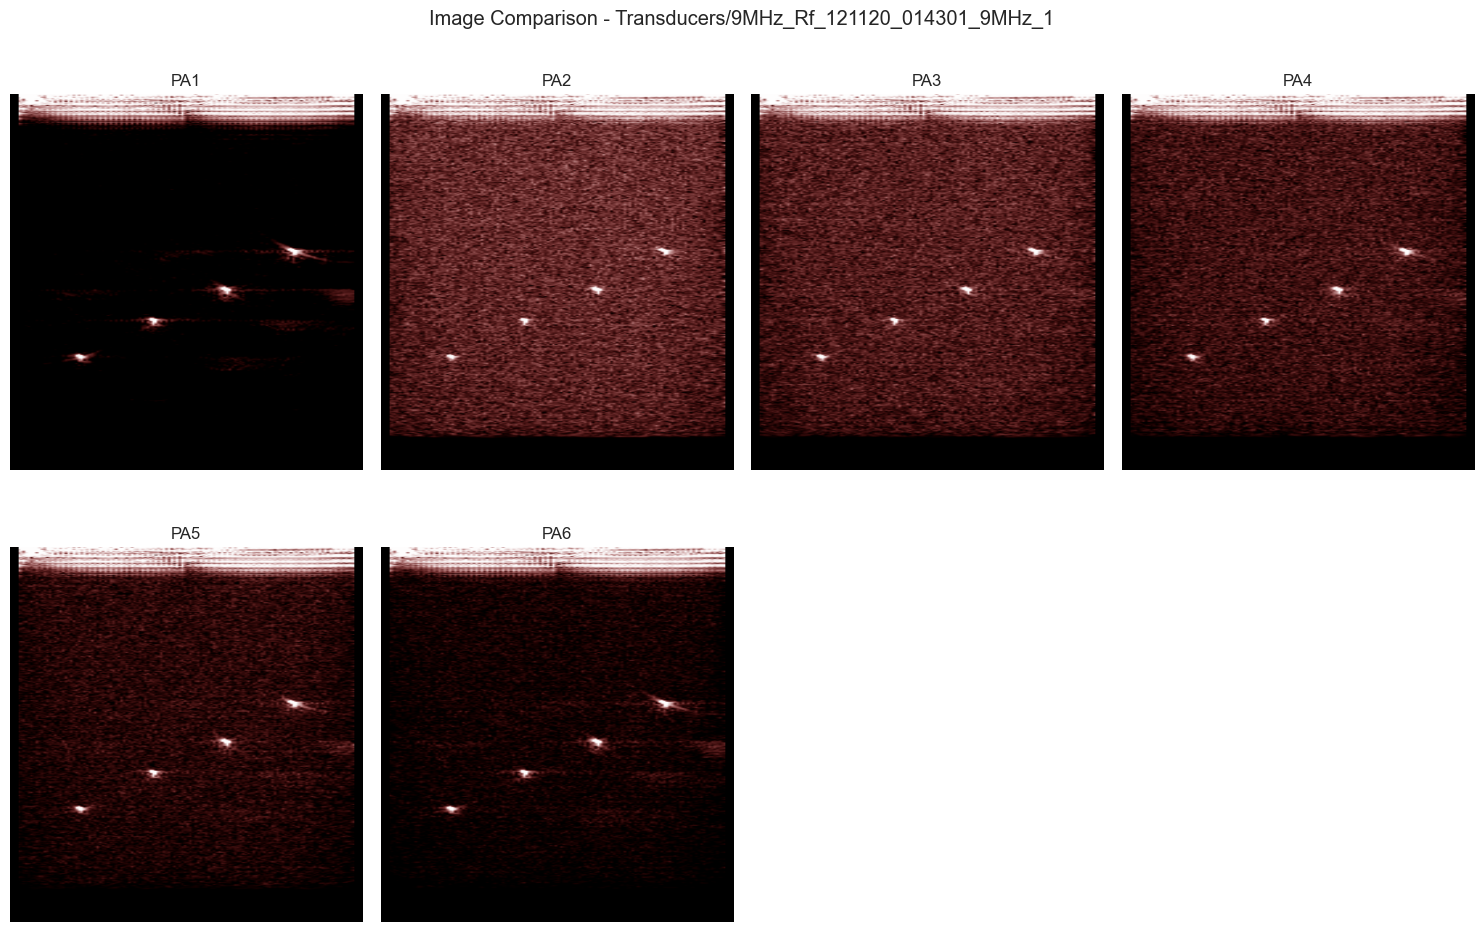

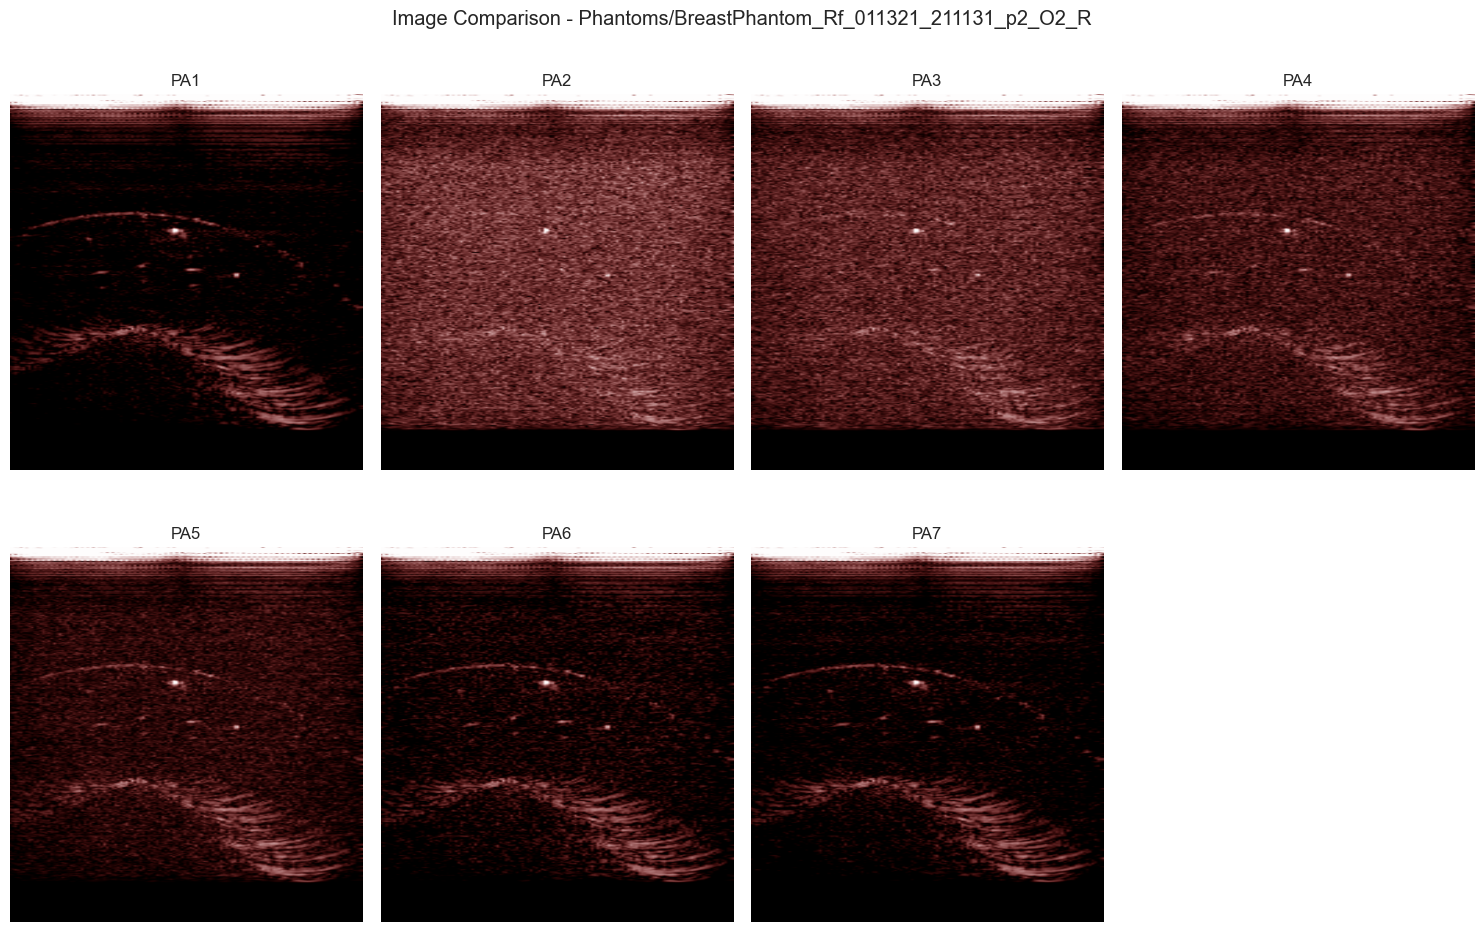

<Figure size 1500x1000 with 0 Axes>

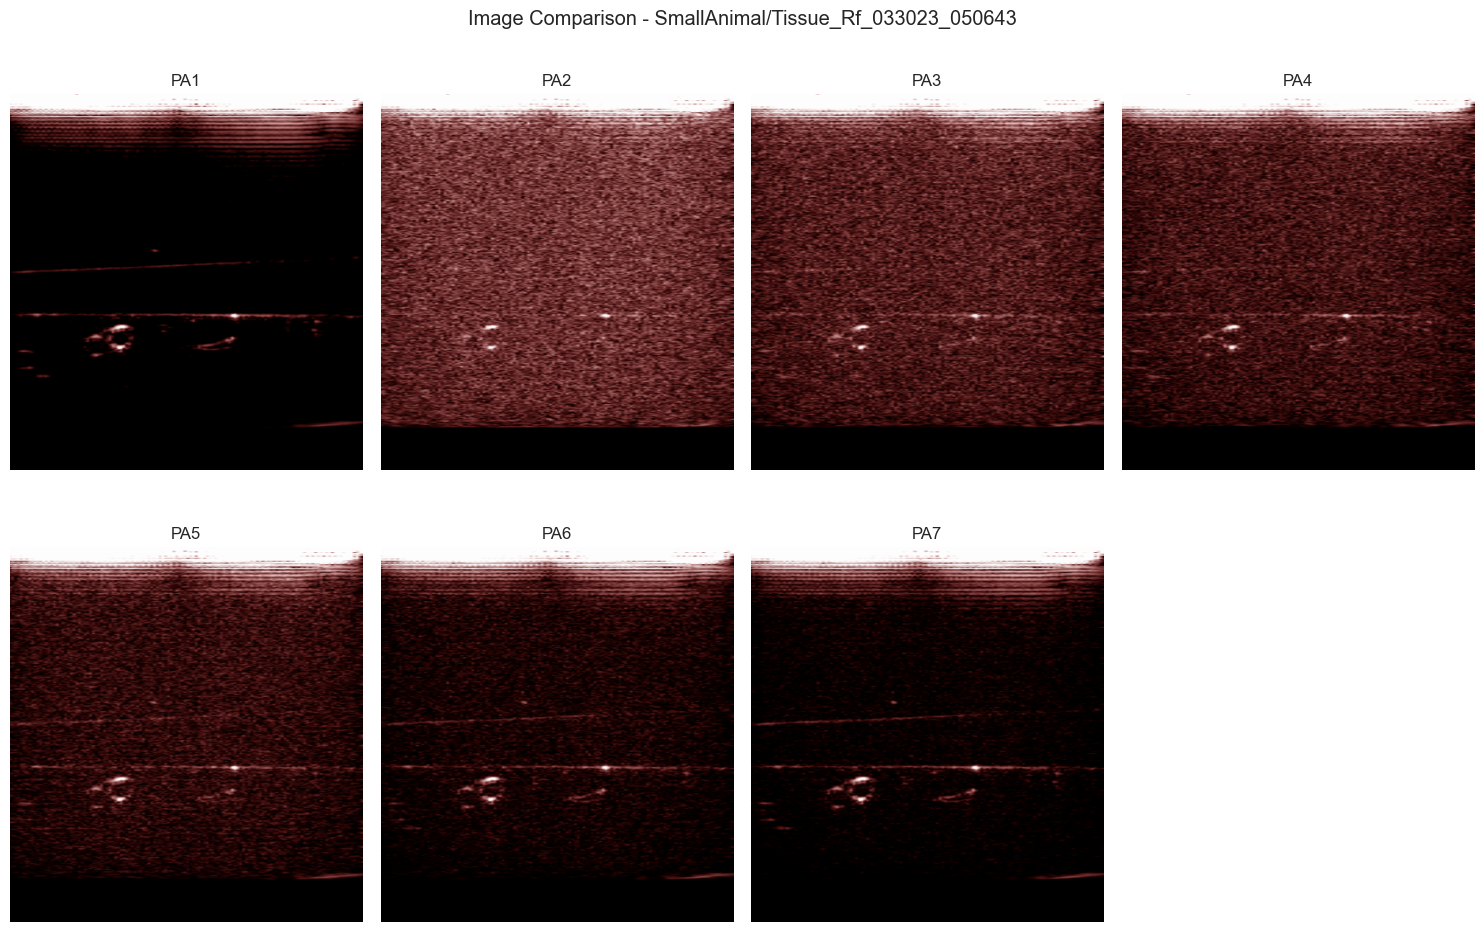

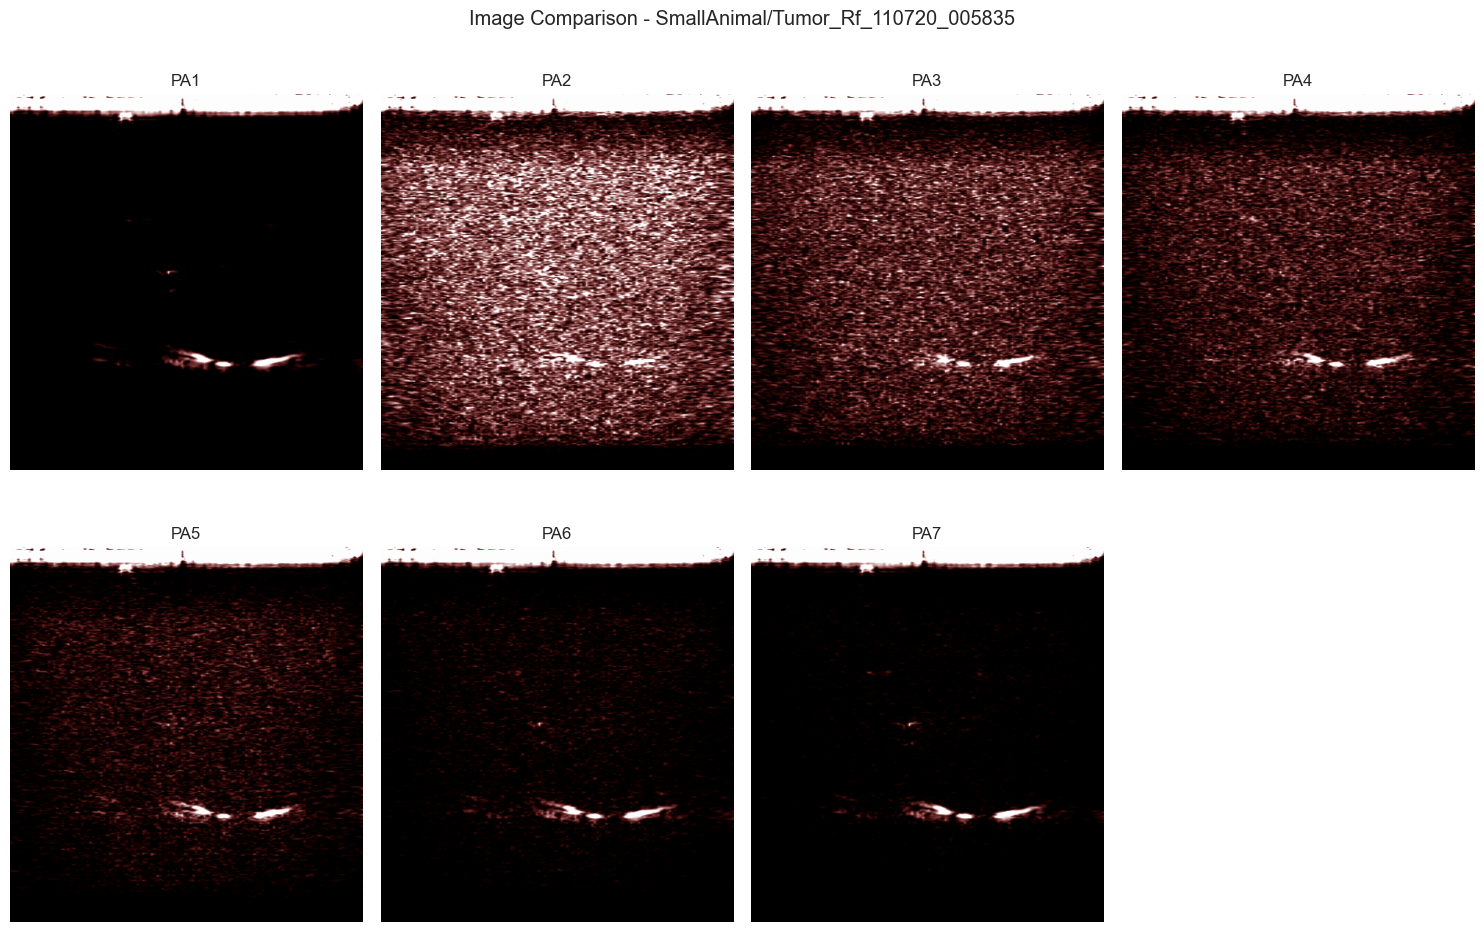

In [36]:
def display_image_comparison(image_dir, title):
    plt.figure(figsize=(15, 10))
    
    # Get all PA images
    image_path = DATA_DIR / "images" / image_dir
    images = []
    for i in range(1, 8):  # PA1 to PA7
        img_path = image_path / f"PA{i}.png"
        if img_path.exists():
            img = plt.imread(str(img_path))
            images.append(img)
    
    # Display images in a grid
    n_images = len(images)
    cols = 4
    rows = (n_images + cols - 1) // cols
    
    for idx, img in enumerate(images):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'PA{idx + 1}')
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display images for each dataset
for img_dir in IMAGE_DIRS:
    display_image_comparison(img_dir, f"Image Comparison - {img_dir}")

## Metric Correlation Analysis
Let's analyze how different metrics correlate with each other:

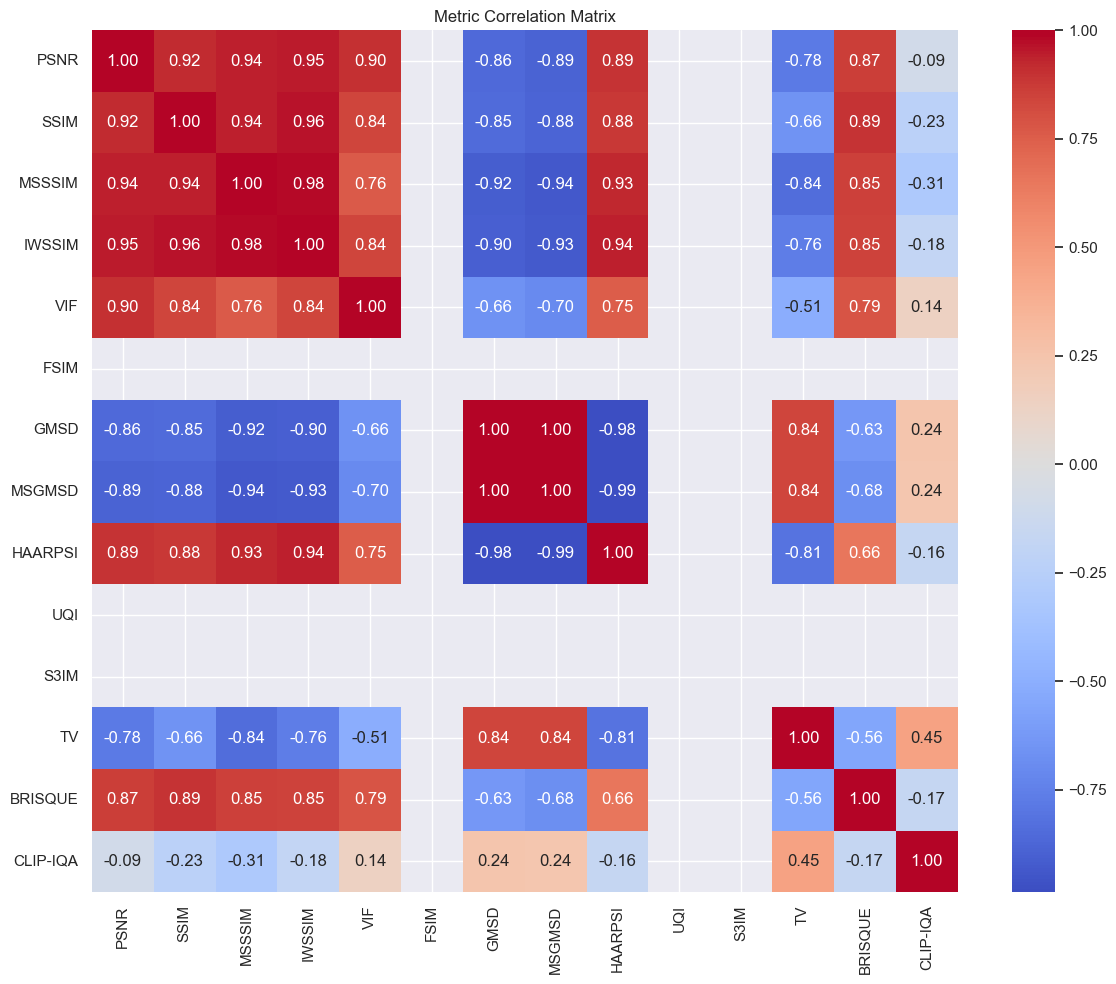


Correlation Matrix:


PSNR      SSIM    MSSSIM    IWSSIM       VIF  FSIM      GMSD    MSGMSD   HAARPSI  UQI  S3IM        TV   BRISQUE  CLIP-IQA
PSNR      1.000000  0.921126  0.941363  0.948536  0.901975   NaN -0.858361 -0.890878  0.891947  NaN   NaN -0.783728  0.865035 -0.093397
SSIM      0.921126  1.000000  0.941835  0.964313  0.838689   NaN -0.852742 -0.881683  0.881446  NaN   NaN -0.656443  0.894236 -0.230998
MSSSIM    0.941363  0.941835  1.000000  0.980787  0.763408   NaN -0.916270 -0.939627  0.925194  NaN   NaN -0.844446  0.854270 -0.305088
IWSSIM    0.948536  0.964313  0.980787  1.000000  0.839215   NaN -0.904731 -0.930608  0.941872  NaN   NaN -0.762559  0.845240 -0.180100
VIF       0.901975  0.838689  0.763408  0.839215  1.000000   NaN -0.660596 -0.704200  0.753079  NaN   NaN -0.510624  0.788703  0.142909
FSIM           NaN       NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN  NaN   NaN       NaN       NaN       NaN
GMSD     -0.858361 -0.852742 -0.916270 -0.904731 -0.660596   NaN  1.000000  0.997339 -0.982147  NaN   NaN  0.837176 -0.634863  0.244742
MSGMSD   -0.890878 -0.881683 -0.939627 -0.930608 -0.704200   NaN  0.997339  1.000000 -0.986404  NaN   NaN  0.842350 -0.682674  0.239168
HAARPSI   0.891947  0.881446  0.925194  0.941872  0.753079   NaN -0.982147 -0.986404  1.000000  NaN   NaN -0.809458  0.655672 -0.164931
UQI            NaN       NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN  NaN   NaN       NaN       NaN       NaN
S3IM           NaN       NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN  NaN   NaN       NaN       NaN       NaN
TV       -0.783728 -0.656443 -0.844446 -0.762559 -0.510624   NaN  0.837176  0.842350 -0.809458  NaN   NaN  1.000000 -0.556509  0.450117
BRISQUE   0.865035  0.894236  0.854270  0.845240  0.788703   NaN -0.634863 -0.682674  0.655672  NaN   NaN -0.556509  1.000000 -0.169334
CLIP-IQA -0.093397 -0.230998 -0.305088 -0.180100  0.142909   NaN  0.244742  0.239168 -0.164931  NaN   NaN  0.450117 -0.169334  1.000000

In [42]:
# First, let's identify the metric columns
# Based on your data, the metrics start from column 4 (PSNR) and go in pairs (mean, std)
metric_names = ['PSNR', 'SSIM', 'MSSSIM', 'IWSSIM', 'VIF', 'FSIM', 'GMSD', 'MSGMSD', 'HAARPSI', 'UQI', 'S3IM', 'TV', 'BRISQUE', 'CLIP-IQA']

# Create a dictionary to map metric names to their column indices
metric_columns = {}
for i, metric in enumerate(metric_names):
    mean_col_idx = 4 + (i * 2)  # Each metric has mean and std columns
    metric_columns[metric] = mean_col_idx

# Create a new DataFrame with just the mean values
metric_df = pd.DataFrame()
for metric, col_idx in metric_columns.items():
    metric_df[metric] = pd.to_numeric(df.iloc[:, col_idx], errors='coerce')

# Calculate correlation matrix
corr_matrix = metric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Metric Correlation Matrix')
plt.tight_layout()
plt.show()

# Print the correlation matrix
print("\nCorrelation Matrix:")
display(corr_matrix)

### Metric Correlations
- Strong positive correlation between:
  - SSIM, MSSSIM, and IWSSIM (>0.94)
  - PSNR and structural metrics (>0.92)
- Strong negative correlation between:
  - GMSD/MSGMSD and structural metrics (<-0.85)
  - TV and quality metrics (<-0.75)

## Configuration Performance Summary
Let's create a summary of how each configuration performs across all metrics:

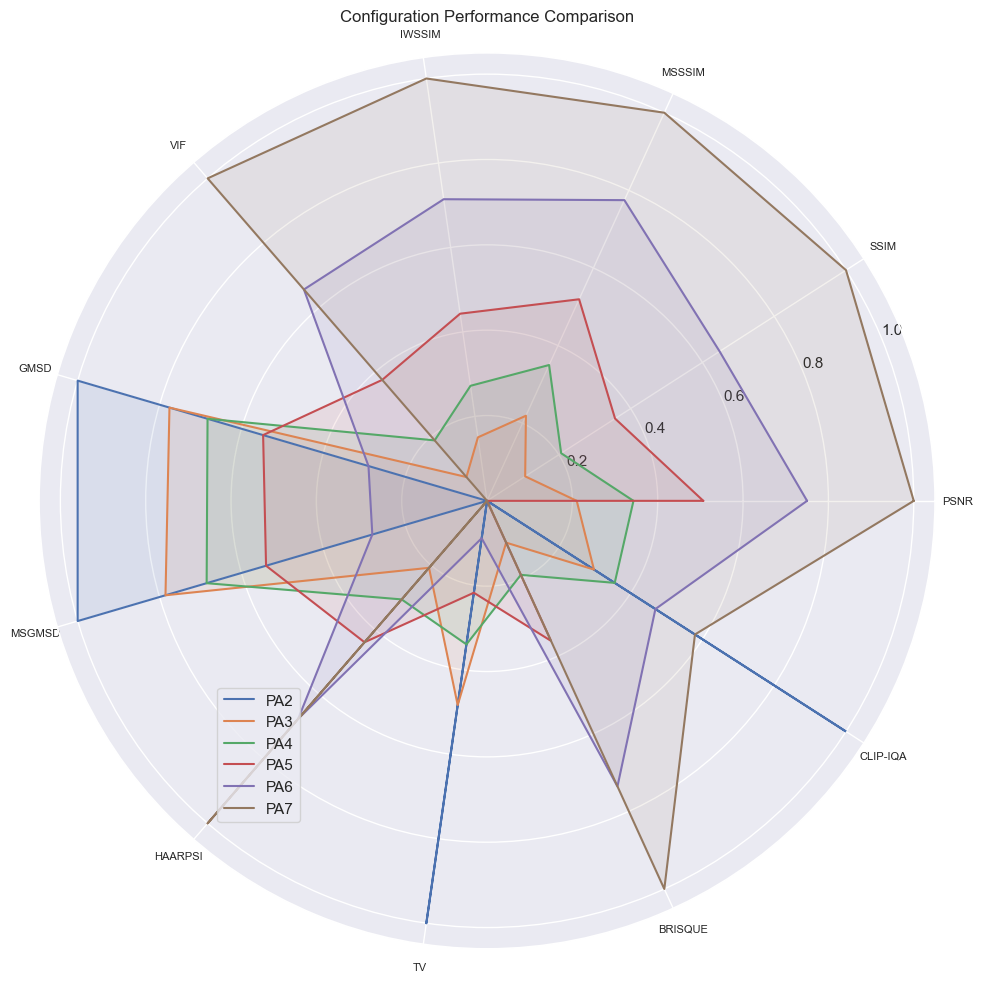

In [44]:
def plot_configuration_summary():
    # Define metric names and their column indices
    metric_names = ['PSNR', 'SSIM', 'MSSSIM', 'IWSSIM', 'VIF', 'FSIM', 'GMSD', 'MSGMSD', 'HAARPSI', 'UQI', 'S3IM', 'TV', 'BRISQUE', 'CLIP-IQA']
    metric_columns = {}
    for i, metric in enumerate(metric_names):
        mean_col_idx = 4 + (i * 2)  # Each metric has mean and std columns
        metric_columns[metric] = mean_col_idx
    
    # Create a new DataFrame with just the mean values
    config_performance = pd.DataFrame()
    for metric, col_idx in metric_columns.items():
        config_performance[metric] = pd.to_numeric(df.iloc[:, col_idx], errors='coerce')
    
    # Add configuration column
    config_performance['Configuration'] = df.iloc[:, 1]  # Second column contains PA2, PA3, etc.
    
    # Group by configuration and calculate mean
    config_performance = config_performance.groupby('Configuration').mean()
    
    # Remove any columns with all NaN values
    config_performance = config_performance.dropna(axis=1, how='all')
    
    # Normalize the metrics (0-1 scale)
    normalized_performance = (config_performance - config_performance.min()) / (config_performance.max() - config_performance.min())
    
    # Plot radar chart
    angles = np.linspace(0, 2*np.pi, len(normalized_performance.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for config in normalized_performance.index:
        values = normalized_performance.loc[config].values
        values = np.concatenate((values, [values[0]]))  # close the loop
        ax.plot(angles, values, label=config)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(normalized_performance.columns, size=8)
    plt.title('Configuration Performance Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(0.3, 0.3))
    plt.tight_layout()
    plt.show()

plot_configuration_summary()

### Overall Findings
- Higher configurations (PA6-PA7) provide significantly better image quality
- Structural similarity metrics are highly correlated
- No-reference metrics (BRISQUE, CLIP-IQA) show moderate correlation with reference-based metrics
- Total Variation (TV) decreases with better configurations, indicating smoother reconstructions